In [1]:
!pip install --upgrade --no-cache-dir gdown
!gdown 18KIvMBWD031oDvg0DVebI06SMwKuTp4l
!pip install pytorch-fid

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l
From (redirected): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l&confirm=t&uuid=345a6409-c573-4de1-83f1-b081895335b2
To: /content/sh3_sc6_y32_x32_imgs.npz
100% 75.5M/75.5M [00:01<00:00, 43.5MB/s]


In [2]:
import os
import torch
import torchvision
import pdb
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.functional import binary_cross_entropy_with_logits
from pytorch_fid import fid_score
from PIL import Image

### Part 1-1

In [3]:
# transform = torchvision.transforms.transforms.Compose([
#     torchvision.transforms.transforms.ToTensor(),
# ])
# imgs = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# imgs = torch.stack([i for i,_ in imgs])

# desired_size = (64, 64)
# imgs = torch.nn.functional.interpolate(imgs, size=desired_size, mode='bilinear', align_corners=False)
# print(resized_tensor.shape)

In [4]:
path = '/content/sh3_sc6_y32_x32_imgs.npz'
imgs = np.load(path, allow_pickle=True, encoding='latin1')['imgs']
imgs.shape

(18432, 64, 64)

In [5]:
real_fid_imgs_indices = np.random.randint(0, imgs.shape[0], size=5000)
real_fid_imgs = [(imgs[img_index] * 255).astype(np.uint8) for img_index in real_fid_imgs_indices]
to_generate_fid_imgs_indices = np.random.randint(0, imgs.shape[0], size=5000)
to_generate_imgs = imgs[to_generate_fid_imgs_indices]

if not os.path.exists('/content/FID_Imgs/Real'):
    os.makedirs('/content/FID_Imgs/Real')
paths = []
for idx, image in enumerate(real_fid_imgs):
    paths.append('/content/FID_Imgs/Real/{}.png'.format(idx))
    Image.fromarray(image, mode='L').save(paths[-1])

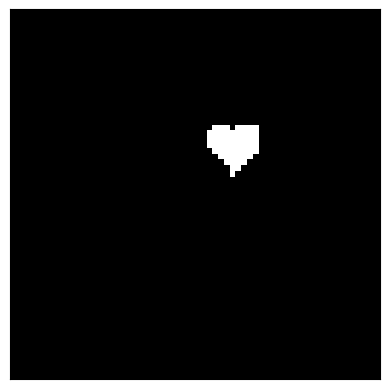

In [6]:
plt.imshow(imgs[13000], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
imgs = torch.from_numpy(imgs.reshape([-1, 1, 64, 64])).float()
train_imgs, test_imgs = train_test_split(imgs, test_size=0.1, random_state=52)
test_imgs, eval_imgs = train_test_split(test_imgs, test_size=0.5, random_state=52)
T_train = train_imgs.shape[0]
T_eval = eval_imgs.shape[0]
T_test = test_imgs.shape[0]
print(train_imgs.shape)
print(eval_imgs.shape)
print(test_imgs.shape)

torch.Size([16588, 1, 64, 64])
torch.Size([922, 1, 64, 64])
torch.Size([922, 1, 64, 64])


### Part 1-2

In [8]:
class VAE(nn.Module):
  def __init__(self, dim_z):
    super(VAE, self).__init__()
    self.encoder_conv = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 256, kernel_size=4),
        nn.ReLU()
    )
    self.FC1 = nn.Linear(256, 256)
    self.mean = nn.Linear(256, dim_z)
    self.logvar = nn.Linear(256, dim_z)
    self.FC2 = nn.Linear(dim_z, 256)
    self.decoder_conv = nn.Sequential(
        nn.ReLU(),
        nn.ConvTranspose2d(256, 64, kernel_size=4),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)
    )
  def forward(self, x):
    x = self.encoder_conv(x)
    x = x.reshape(x.size(0), -1)
    x = self.FC1(x)
    means = self.mean(x)
    logvars = self.logvar(x)
    stds = torch.exp(0.5*logvars)
    z = stds*torch.randn_like(stds)+means
    z = self.FC2(z)
    z = z.reshape(z.size(0), -1, 1, 1)
    x = self.decoder_conv(z)
    return x, means, stds, z

#### Model 1: Simple VAE

In [9]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

dim_z = 10
model1 = VAE(dim_z).to(device)
train_imgs = train_imgs.to(device)
eval_imgs = eval_imgs.to(device)
test_imgs = test_imgs.to(device)

epochs = 250
batch_size = 64
learning_rate = 1e-4
train_data_loader = DataLoader(train_imgs, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

model1_train_reconstruction_loss_list = []
model1_train_KL_loss_list = []
model1_train_loss_list = []

model1_eval_reconstruction_loss_list = []
model1_eval_KL_loss_list = []
model1_eval_loss_list = []
for epoch in range(epochs):
  for i, in_imgs in enumerate(train_data_loader):
    out_imgs, means, stds, z = model1(in_imgs)

    reconstruction_loss = torch.sum(torch.mean(binary_cross_entropy_with_logits(out_imgs, in_imgs, reduction='none'), dim=0))
    KL_loss = torch.mean(0.5*torch.sum((stds.pow(2))+(means.pow(2))-2*stds.log()-1, dim=1))
    loss = reconstruction_loss+KL_loss
    model1_train_reconstruction_loss_list.append(reconstruction_loss.cpu().detach().numpy())
    model1_train_KL_loss_list.append(KL_loss.cpu().detach().numpy())
    model1_train_loss_list.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch+1}/{epochs}\t-> Train Loss: \t\t{loss:.2f}\t, Train Reconstruction Loss: \t\t{reconstruction_loss:.2f}\t, Train KL Loss: \t{KL_loss:.5f}')

  out_imgs, means, stds, z = model1(eval_imgs)
  reconstruction_loss = torch.sum(torch.mean(binary_cross_entropy_with_logits(out_imgs, eval_imgs, reduction='none'), dim=0))
  KL_loss = torch.mean(0.5*torch.sum((stds.pow(2))+(means.pow(2))-2*stds.log()-1, dim=1))
  loss = reconstruction_loss + KL_loss
  model1_eval_reconstruction_loss_list.append(reconstruction_loss.cpu().detach().numpy())
  model1_eval_KL_loss_list.append(KL_loss.cpu().detach().numpy())
  model1_eval_loss_list.append(loss.cpu().detach().numpy())

  print(f'\t\t   Evaluation Loss: \t{loss:.2f}\t, Evaluation Reconstruction Loss: \t{reconstruction_loss:.2f}\t, Evaluation KL Loss: \t{KL_loss:.5f}\n')

Epoch 1/250	-> Train Loss: 		670.89	, Train Reconstruction Loss: 		657.37	, Train KL Loss: 	13.51514
		   Evaluation Loss: 	631.15	, Evaluation Reconstruction Loss: 	617.56	, Evaluation KL Loss: 	13.58842

Epoch 2/250	-> Train Loss: 		578.29	, Train Reconstruction Loss: 		569.41	, Train KL Loss: 	8.88205
		   Evaluation Loss: 	550.83	, Evaluation Reconstruction Loss: 	542.14	, Evaluation KL Loss: 	8.69013

Epoch 3/250	-> Train Loss: 		216.66	, Train Reconstruction Loss: 		195.59	, Train KL Loss: 	21.06356
		   Evaluation Loss: 	233.25	, Evaluation Reconstruction Loss: 	212.38	, Evaluation KL Loss: 	20.87211

Epoch 4/250	-> Train Loss: 		171.62	, Train Reconstruction Loss: 		150.79	, Train KL Loss: 	20.82330
		   Evaluation Loss: 	193.61	, Evaluation Reconstruction Loss: 	172.85	, Evaluation KL Loss: 	20.75887

Epoch 5/250	-> Train Loss: 		140.94	, Train Reconstruction Loss: 		118.46	, Train KL Loss: 	22.48077
		   Evaluation Loss: 	122.59	, Evaluation Reconstruction Loss: 	99.40	, Eval

### Part 1-3

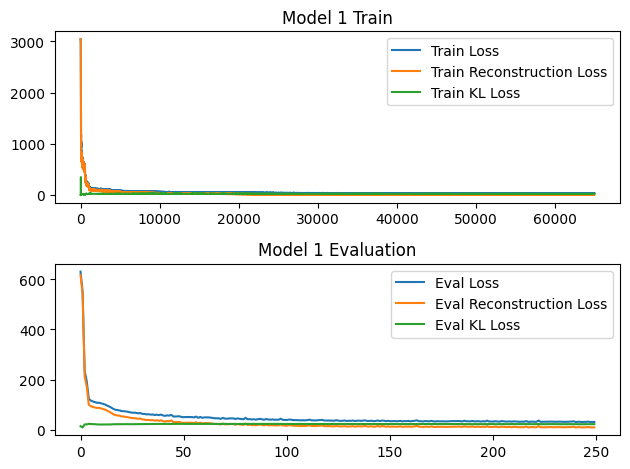

In [10]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(model1_train_loss_list, label='Train Loss')
axes[0].plot(model1_train_reconstruction_loss_list, label='Train Reconstruction Loss')
axes[0].plot(model1_train_KL_loss_list, label='Train KL Loss')
axes[0].legend()
axes[0].set_title('Model 1 Train')

axes[1].plot(model1_eval_loss_list, label='Eval Loss')
axes[1].plot(model1_eval_reconstruction_loss_list, label='Eval Reconstruction Loss')
axes[1].plot(model1_eval_KL_loss_list, label='Eval KL Loss')
axes[1].legend()
axes[1].set_title('Model 1 Evaluation')

plt.tight_layout()
plt.show()

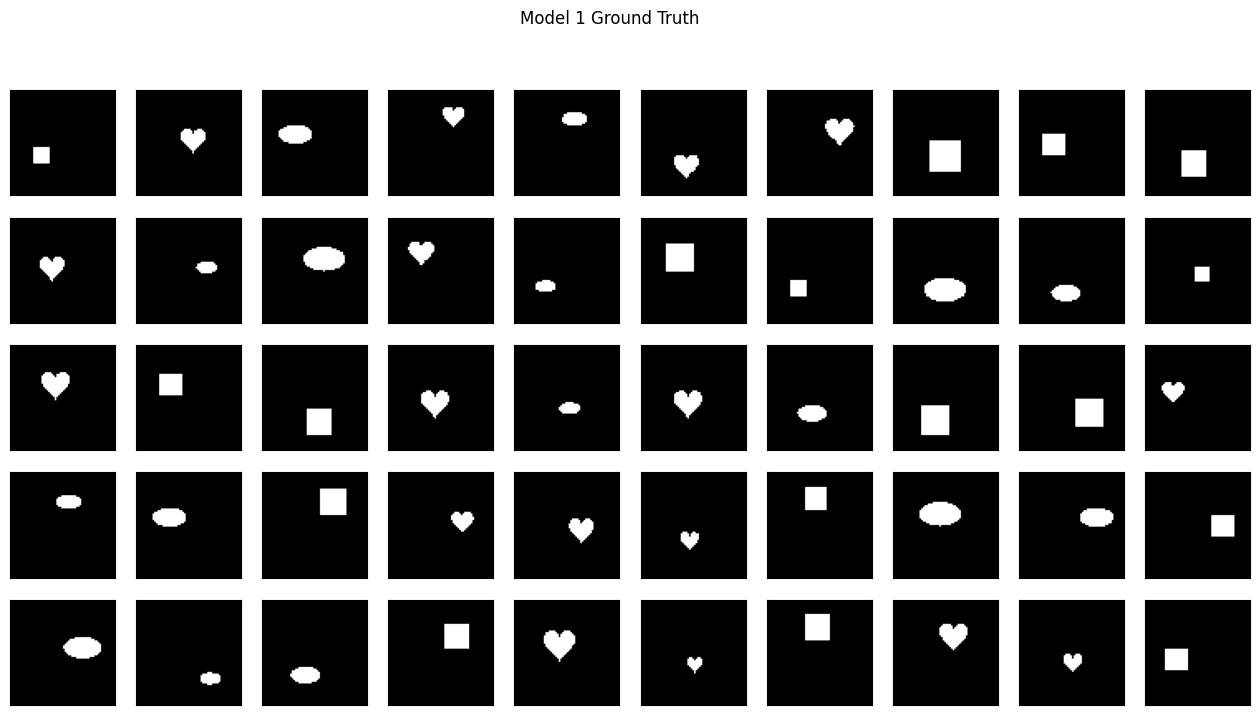

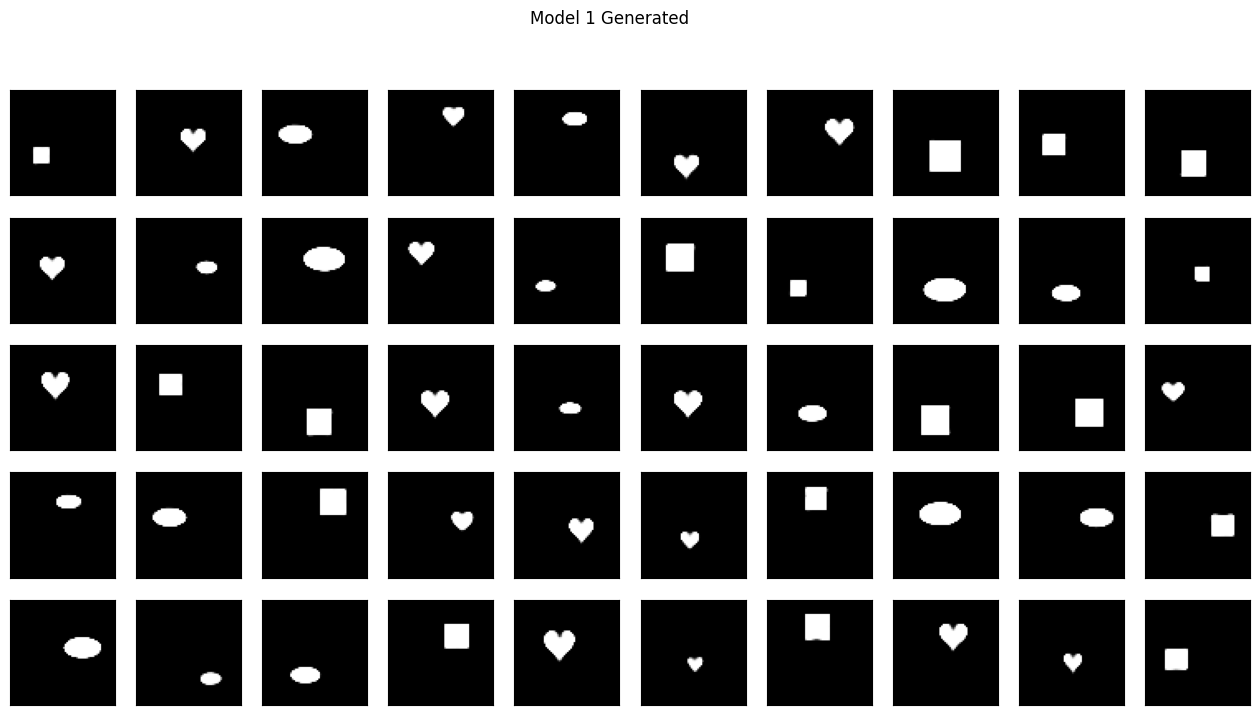

In [11]:
indices = np.random.randint(0, T_test, size=50)

in_x = test_imgs[indices]
out_x, means, std, z = model1(in_x)
activation = nn.Sigmoid()
out_x = activation(out_x)

fig1, axes1 = plt.subplots(5, 10, figsize=(16,8))
fig1.suptitle('Model 1 Ground Truth')
fig2, axes2 = plt.subplots(5, 10, figsize=(16,8))
fig2.suptitle('Model 1 Generated')

for i in range(50):
  axes1[i//10, i%10].imshow(in_x[i].reshape([64,64]).cpu().detach().numpy(), cmap='gray')
  axes1[i//10, i%10].set_xticks([])
  axes1[i//10, i%10].set_yticks([])
  axes2[i//10, i%10].imshow(out_x[i].reshape([64,64]).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
  axes2[i//10, i%10].set_xticks([])
  axes2[i//10, i%10].set_yticks([])
plt.show()

In [12]:
model1_generated_imgs, _, _, _ = model1(torch.from_numpy(to_generate_imgs.reshape([-1, 1, 64, 64])).float().to(device))
model1_generated_imgs = activation(model1_generated_imgs)
model1_generated_imgs = [(img.cpu().detach().numpy().reshape([64, 64]) * 255).astype(np.uint8) for img in model1_generated_imgs]


if not os.path.exists('/content/FID_Imgs/Model 1'):
  os.makedirs('/content/FID_Imgs/Model 1')
paths = []
for idx, image in enumerate(model1_generated_imgs):
  paths.append('/content/FID_Imgs/Model 1/{}.png'.format(idx))
  Image.fromarray(image, mode='L').save(paths[-1])
FID_model1 = fid_score.calculate_fid_given_paths(paths=['/content/FID_Imgs/Real', '/content/FID_Imgs/Model 1'], batch_size=256, dims=2048, device=device)
print(f'Model 1 Generated Images FID: {FID_model1}')

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 72.6MB/s]
100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Model 1 Generated Images FID: 29.41410906522333


### Part 1-4

In [13]:
def Beta_Calculator(deisred_KL, KL_loss, Kp, Ki, beta, I, beta_max, beta_min):
  e = deisred_KL-KL_loss
  P = Kp/(1+np.exp(e))
  if(beta>=beta_min and beta<=beta_max):
    I_new = I-Ki*e
  else:
    I_new = I
  beta_new = P+I_new+beta_min
  if(beta_new>beta_max):
    beta_new = beta_max
  elif(beta_new<beta_min):
    beta_new=beta_min
  return beta_new, I_new

#### Model 2: Controled VAE (KL=8)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

dim_z = 10
model2 = VAE(dim_z).to(device)
train_imgs = train_imgs.to(device)
eval_imgs = eval_imgs.to(device)
test_imgs = test_imgs.to(device)

epochs = 250
batch_size = 64
learning_rate = 1e-4
train_data_loader = DataLoader(train_imgs, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

model2_train_reconstruction_loss_list = []
model2_train_KL_loss_list = []
model2_train_loss_list = []

model2_eval_reconstruction_loss_list = []
model2_eval_KL_loss_list = []
model2_eval_loss_list = []

I = 0
beta = 0
beta_min = 1
beta_max = 50
Kp = 0.01
Ki = 0.001
desired_KL = 8
beta_list = []
for epoch in range(epochs):
  for i, in_imgs in enumerate(train_data_loader):
    out_imgs, means, stds, z = model2(in_imgs)

    reconstruction_loss = torch.sum(torch.mean(binary_cross_entropy_with_logits(out_imgs, in_imgs, reduction='none'), dim=0))
    KL_loss = torch.mean(0.5*torch.sum((stds.pow(2))+(means.pow(2))-2*stds.log()-1, dim=1))
    beta, I = Beta_Calculator(desired_KL, KL_loss.cpu().detach().numpy(), Kp, Ki, beta, I, beta_max, beta_min)
    loss = reconstruction_loss+beta*KL_loss
    beta_list.append(beta)
    model2_train_reconstruction_loss_list.append(reconstruction_loss.cpu().detach().numpy())
    model2_train_KL_loss_list.append(KL_loss.cpu().detach().numpy())
    model2_train_loss_list.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch+1}/{epochs}\t-> Train Loss: \t\t{loss:.2f}\t, Train Reconstruction Loss: \t\t{reconstruction_loss:.2f}\t, Train KL Loss: \t{KL_loss:.5f}')

  out_imgs, means, stds, z = model2(eval_imgs)
  reconstruction_loss = torch.sum(torch.mean(binary_cross_entropy_with_logits(out_imgs, eval_imgs, reduction='none'), dim=0))
  KL_loss = torch.mean(0.5*torch.sum((stds.pow(2))+(means.pow(2))-2*stds.log()-1, dim=1))
  loss = reconstruction_loss + KL_loss
  model2_eval_reconstruction_loss_list.append(reconstruction_loss.cpu().detach().numpy())
  model2_eval_KL_loss_list.append(KL_loss.cpu().detach().numpy())
  model2_eval_loss_list.append(loss.cpu().detach().numpy())

  print(f'\t\t   Evaluation Loss: \t{loss:.2f}\t, Evaluation Reconstruction Loss: \t{reconstruction_loss:.2f}\t, Evaluation KL Loss: \t{KL_loss:.5f}\n\t\t   beta: {beta:.3f}')

Epoch 1/250	-> Train Loss: 		582.67	, Train Reconstruction Loss: 		567.62	, Train KL Loss: 	7.09640
		   Evaluation Loss: 	626.35	, Evaluation Reconstruction Loss: 	619.23	, Evaluation KL Loss: 	7.12620
		   beta: 2.121
Epoch 2/250	-> Train Loss: 		482.24	, Train Reconstruction Loss: 		471.10	, Train KL Loss: 	6.78741
		   Evaluation Loss: 	570.10	, Evaluation Reconstruction Loss: 	564.13	, Evaluation KL Loss: 	5.97101
		   beta: 1.641
Epoch 3/250	-> Train Loss: 		247.67	, Train Reconstruction Loss: 		213.74	, Train KL Loss: 	14.60346
		   Evaluation Loss: 	246.99	, Evaluation Reconstruction Loss: 	232.90	, Evaluation KL Loss: 	14.08482
		   beta: 2.324
Epoch 4/250	-> Train Loss: 		195.22	, Train Reconstruction Loss: 		131.34	, Train KL Loss: 	15.39544
		   Evaluation Loss: 	140.51	, Evaluation Reconstruction Loss: 	125.51	, Evaluation KL Loss: 	15.00472
		   beta: 4.149
Epoch 5/250	-> Train Loss: 		191.98	, Train Reconstruction Loss: 		121.42	, Train KL Loss: 	12.65339
		   Evaluation

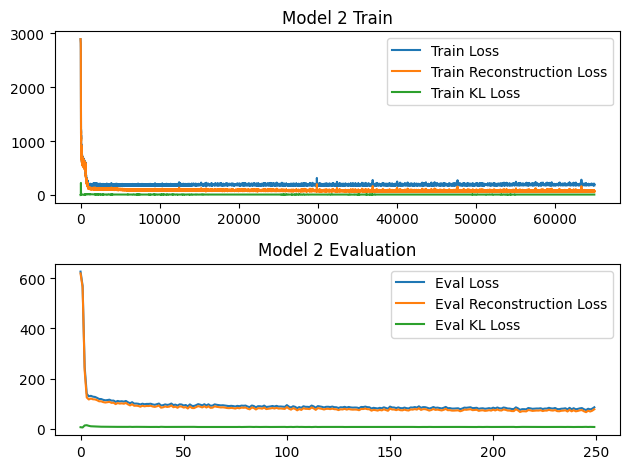

In [15]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(model2_train_loss_list, label='Train Loss')
axes[0].plot(model2_train_reconstruction_loss_list, label='Train Reconstruction Loss')
axes[0].plot(model2_train_KL_loss_list, label='Train KL Loss')
axes[0].legend()
axes[0].set_title('Model 2 Train')

axes[1].plot(model2_eval_loss_list, label='Eval Loss')
axes[1].plot(model2_eval_reconstruction_loss_list, label='Eval Reconstruction Loss')
axes[1].plot(model2_eval_KL_loss_list, label='Eval KL Loss')
axes[1].legend()
axes[1].set_title('Model 2 Evaluation')

plt.tight_layout()
plt.show()

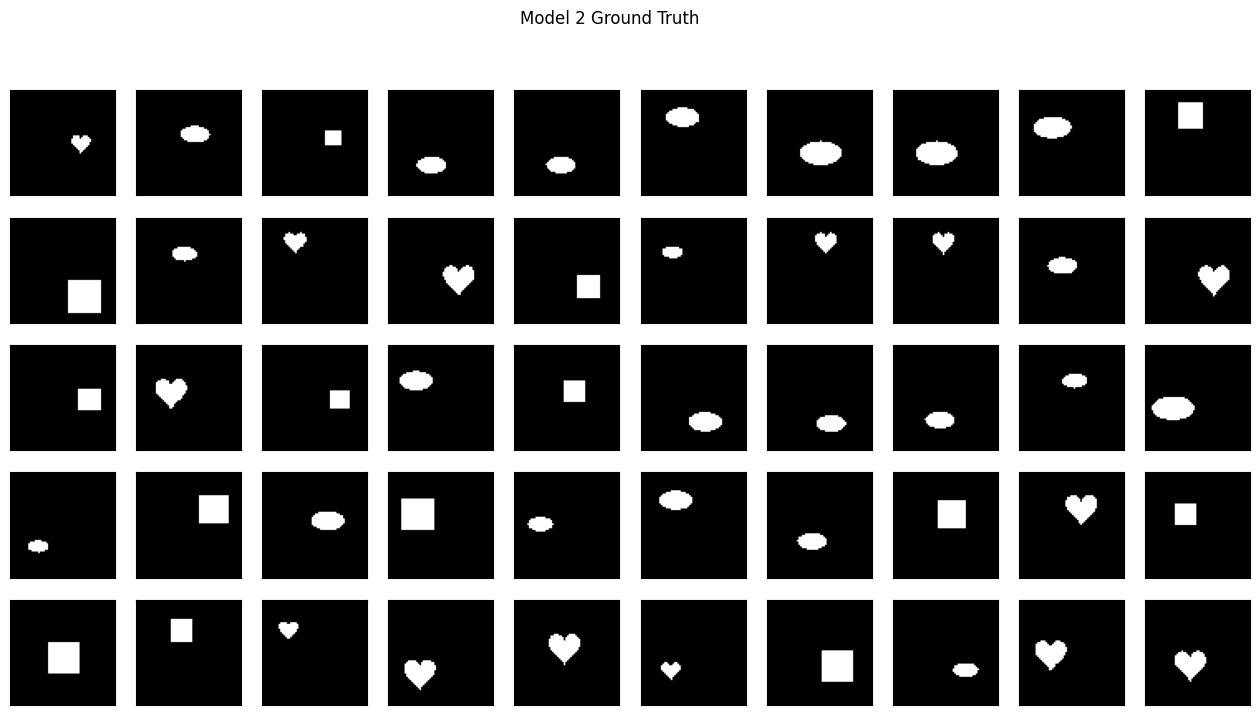

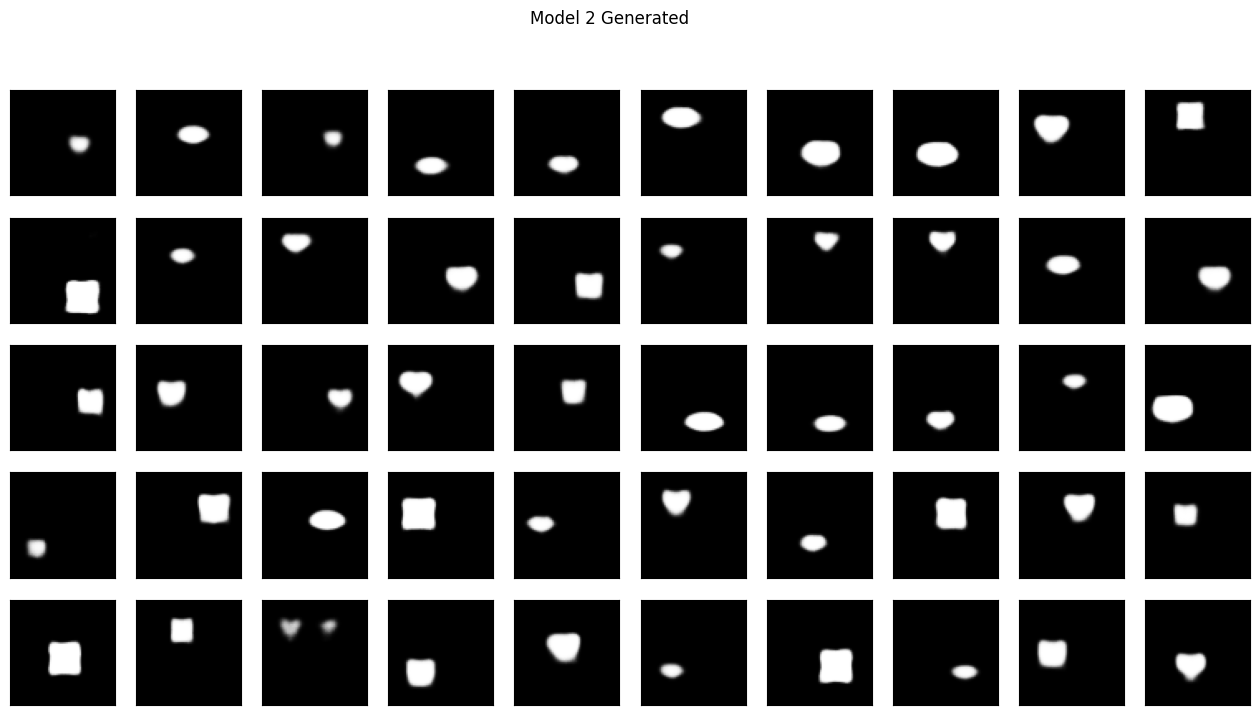

In [16]:
indices = np.random.randint(0, T_test, size=50)

in_x = test_imgs[indices]
out_x, means, std, z = model2(in_x)
activation = nn.Sigmoid()
out_x = activation(out_x)

fig1, axes1 = plt.subplots(5, 10, figsize=(16,8))
fig1.suptitle('Model 2 Ground Truth')
fig2, axes2 = plt.subplots(5, 10, figsize=(16,8))
fig2.suptitle('Model 2 Generated')

for i in range(50):
  axes1[i//10, i%10].imshow(in_x[i].reshape([64,64]).cpu().detach().numpy(), cmap='gray')
  axes1[i//10, i%10].set_xticks([])
  axes1[i//10, i%10].set_yticks([])
  axes2[i//10, i%10].imshow(out_x[i].reshape([64,64]).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
  axes2[i//10, i%10].set_xticks([])
  axes2[i//10, i%10].set_yticks([])
plt.show()

In [17]:
model2_generated_imgs, _, _, _ = model2(torch.from_numpy(to_generate_imgs.reshape([-1, 1, 64, 64])).float().to(device))
model2_generated_imgs = activation(model2_generated_imgs)
model2_generated_imgs = [(img.cpu().detach().numpy().reshape([64, 64]) * 255).astype(np.uint8) for img in model2_generated_imgs]


if not os.path.exists('/content/FID_Imgs/Model 2'):
  os.makedirs('/content/FID_Imgs/Model 2')
paths = []
for idx, image in enumerate(model2_generated_imgs):
  paths.append('/content/FID_Imgs/Model 2/{}.png'.format(idx))
  Image.fromarray(image, mode='L').save(paths[-1])
FID_model1 = fid_score.calculate_fid_given_paths(paths=['/content/FID_Imgs/Real', '/content/FID_Imgs/Model 2'], batch_size=256, dims=2048, device=device)
print(f'Model 2 Generated Images FID: {FID_model1}')

100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Model 2 Generated Images FID: 117.71792515739791


#### Model 3: Controled VAE (KL=14)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

dim_z = 10
model3 = VAE(dim_z).to(device)
train_imgs = train_imgs.to(device)
eval_imgs = eval_imgs.to(device)
test_imgs = test_imgs.to(device)

epochs = 250
batch_size = 64
learning_rate = 1e-4
train_data_loader = DataLoader(train_imgs, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

model3_train_reconstruction_loss_list = []
model3_train_KL_loss_list = []
model3_train_loss_list = []

model3_eval_reconstruction_loss_list = []
model3_eval_KL_loss_list = []
model3_eval_loss_list = []

I = 0
beta = 0
beta_min = 1
beta_max = 50
Kp = 0.01
Ki = 0.001
desired_KL = 14
beta_list = []
for epoch in range(epochs):
  for i, in_imgs in enumerate(train_data_loader):
    out_imgs, means, stds, z = model3(in_imgs)

    reconstruction_loss = torch.sum(torch.mean(binary_cross_entropy_with_logits(out_imgs, in_imgs, reduction='none'), dim=0))
    KL_loss = torch.mean(0.5*torch.sum((stds.pow(2))+(means.pow(2))-2*stds.log()-1, dim=1))
    beta, I = Beta_Calculator(desired_KL, KL_loss.cpu().detach().numpy(), Kp, Ki, beta, I, beta_max, beta_min)
    loss = reconstruction_loss+beta*KL_loss
    beta_list.append(beta)
    model3_train_reconstruction_loss_list.append(reconstruction_loss.cpu().detach().numpy())
    model3_train_KL_loss_list.append(KL_loss.cpu().detach().numpy())
    model3_train_loss_list.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch+1}/{epochs}\t-> Train Loss: \t\t{loss:.2f}\t, Train Reconstruction Loss: \t\t{reconstruction_loss:.2f}\t, Train KL Loss: \t{KL_loss:.5f}')

  out_imgs, means, stds, z = model3(eval_imgs)
  reconstruction_loss = torch.sum(torch.mean(binary_cross_entropy_with_logits(out_imgs, eval_imgs, reduction='none'), dim=0))
  KL_loss = torch.mean(0.5*torch.sum((stds.pow(2))+(means.pow(2))-2*stds.log()-1, dim=1))
  loss = reconstruction_loss + KL_loss
  model3_eval_reconstruction_loss_list.append(reconstruction_loss.cpu().detach().numpy())
  model3_eval_KL_loss_list.append(KL_loss.cpu().detach().numpy())
  model3_eval_loss_list.append(loss.cpu().detach().numpy())

  print(f'\t\t   Evaluation Loss: \t{loss:.2f}\t, Evaluation Reconstruction Loss: \t{reconstruction_loss:.2f}\t, Evaluation KL Loss: \t{KL_loss:.5f}\n\t\t   beta: {beta:.3f}')

Epoch 1/250	-> Train Loss: 		607.27	, Train Reconstruction Loss: 		593.31	, Train KL Loss: 	8.00073
		   Evaluation Loss: 	629.53	, Evaluation Reconstruction Loss: 	621.49	, Evaluation KL Loss: 	8.04528
		   beta: 1.745
Epoch 2/250	-> Train Loss: 		385.86	, Train Reconstruction Loss: 		367.82	, Train KL Loss: 	18.03722
		   Evaluation Loss: 	389.09	, Evaluation Reconstruction Loss: 	368.42	, Evaluation KL Loss: 	20.67521
		   beta: 1.000
Epoch 3/250	-> Train Loss: 		206.89	, Train Reconstruction Loss: 		173.06	, Train KL Loss: 	17.68694
		   Evaluation Loss: 	221.28	, Evaluation Reconstruction Loss: 	204.62	, Evaluation KL Loss: 	16.65550
		   beta: 1.913
Epoch 4/250	-> Train Loss: 		158.26	, Train Reconstruction Loss: 		106.09	, Train KL Loss: 	17.12222
		   Evaluation Loss: 	133.34	, Evaluation Reconstruction Loss: 	116.38	, Evaluation KL Loss: 	16.96251
		   beta: 3.047
Epoch 5/250	-> Train Loss: 		156.96	, Train Reconstruction Loss: 		101.26	, Train KL Loss: 	15.23757
		   Evaluati

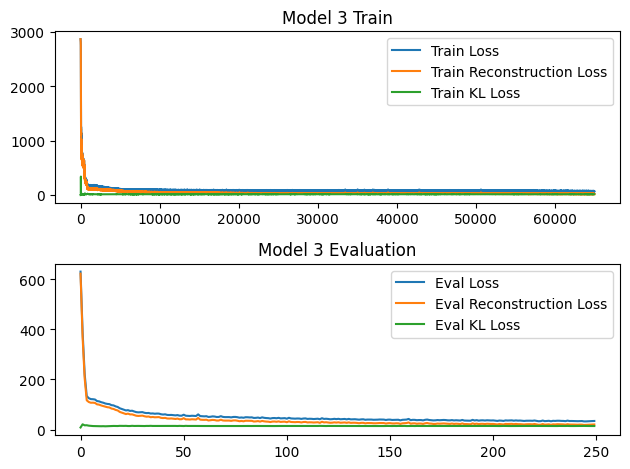

In [19]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(model3_train_loss_list, label='Train Loss')
axes[0].plot(model3_train_reconstruction_loss_list, label='Train Reconstruction Loss')
axes[0].plot(model3_train_KL_loss_list, label='Train KL Loss')
axes[0].legend()
axes[0].set_title('Model 3 Train')

axes[1].plot(model3_eval_loss_list, label='Eval Loss')
axes[1].plot(model3_eval_reconstruction_loss_list, label='Eval Reconstruction Loss')
axes[1].plot(model3_eval_KL_loss_list, label='Eval KL Loss')
axes[1].legend()
axes[1].set_title('Model 3 Evaluation')

plt.tight_layout()
plt.show()

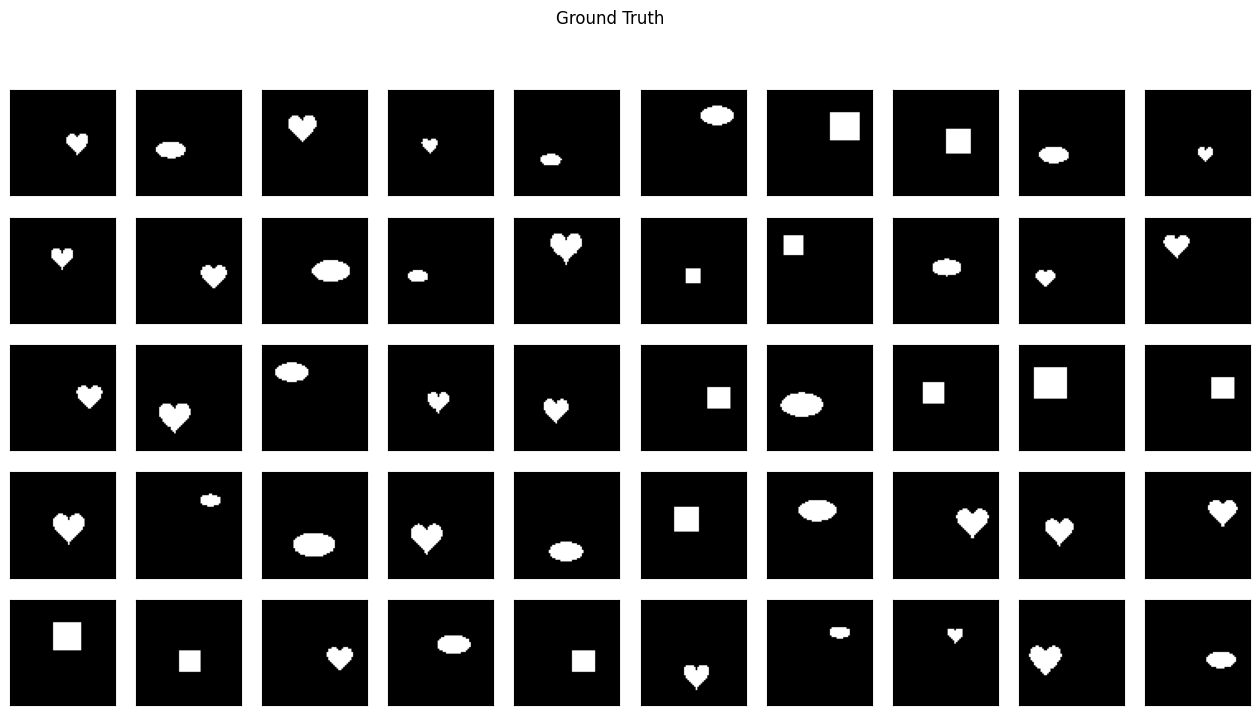

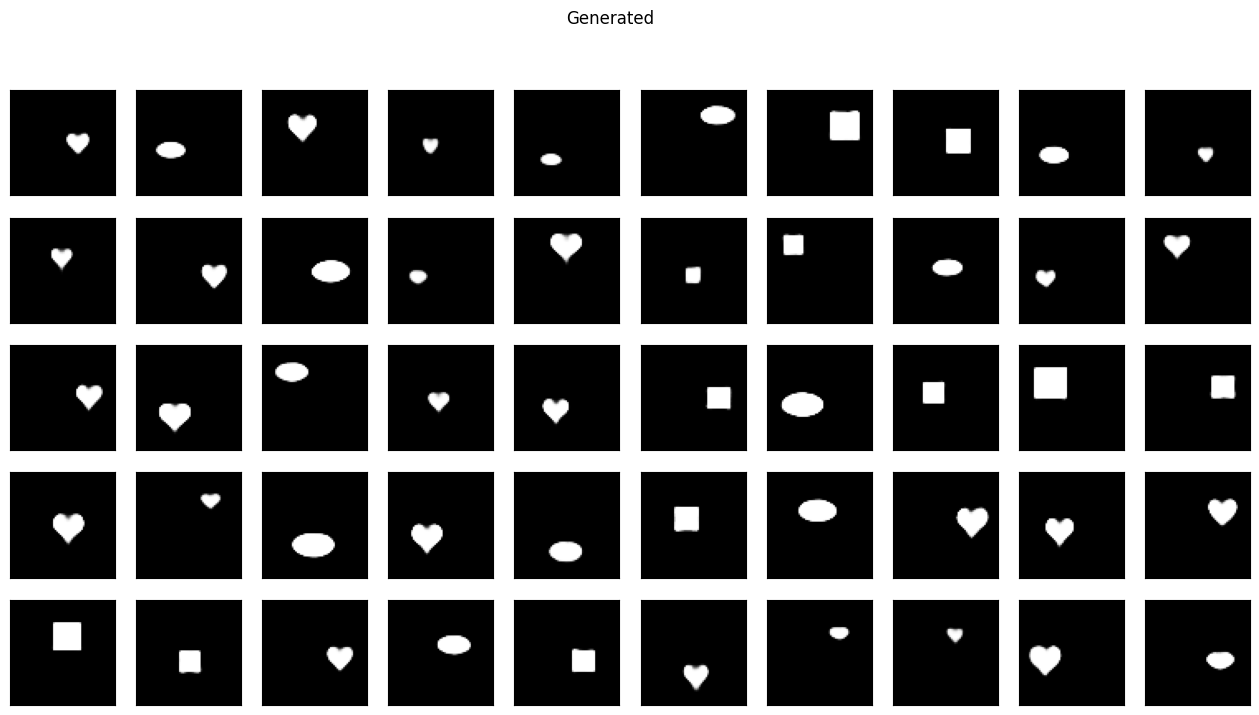

In [20]:
indices = np.random.randint(0, T_test, size=50)

in_x = test_imgs[indices]
out_x, means, std, z = model3(in_x)
activation = nn.Sigmoid()
out_x = activation(out_x)

fig1, axes1 = plt.subplots(5, 10, figsize=(16,8))
fig1.suptitle('Ground Truth')
fig2, axes2 = plt.subplots(5, 10, figsize=(16,8))
fig2.suptitle('Generated')

for i in range(50):
  axes1[i//10, i%10].imshow(in_x[i].reshape([64,64]).cpu().detach().numpy(), cmap='gray')
  axes1[i//10, i%10].set_xticks([])
  axes1[i//10, i%10].set_yticks([])
  axes2[i//10, i%10].imshow(out_x[i].reshape([64,64]).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
  axes2[i//10, i%10].set_xticks([])
  axes2[i//10, i%10].set_yticks([])
plt.show()

In [ ]:
model3_generated_imgs, _, _, _ = model3(torch.from_numpy(to_generate_imgs.reshape([-1, 1, 64, 64])).float().to(device))
model3_generated_imgs = activation(model3_generated_imgs)
model3_generated_imgs = [(img.cpu().detach().numpy().reshape([64, 64]) * 255).astype(np.uint8) for img in model3_generated_imgs]


if not os.path.exists('/content/FID_Imgs/Model 3'):
  os.makedirs('/content/FID_Imgs/Model 3')
paths = []
for idx, image in enumerate(model3_generated_imgs):
  paths.append('/content/FID_Imgs/Model 3/{}.png'.format(idx))
  Image.fromarray(image, mode='L').save(paths[-1])
FID_model1 = fid_score.calculate_fid_given_paths(paths=['/content/FID_Imgs/Real', '/content/FID_Imgs/Model 3'], batch_size=256, dims=2048, device=device)
print(f'Model 3 Generated Images FID: {FID_model1}')

100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Model 3 Generated Images FID: 66.57572985468784


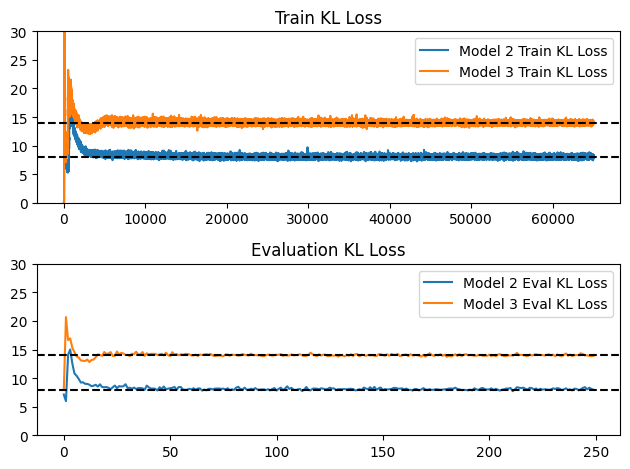

In [21]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(model2_train_KL_loss_list, label='Model 2 Train KL Loss')
axes[0].plot(model3_train_KL_loss_list, label='Model 3 Train KL Loss')
axes[0].legend()
axes[0].set_ylim(0, 30)
axes[0].axhline(y=8, color='black', linestyle='--')
axes[0].axhline(y=14, color='black', linestyle='--')
axes[0].set_title('Train KL Loss')

axes[1].plot(model2_eval_KL_loss_list, label='Model 2 Eval KL Loss')
axes[1].plot(model3_eval_KL_loss_list, label='Model 3 Eval KL Loss')
axes[1].legend()
axes[1].set_ylim(0, 30)
axes[1].axhline(y=8, color='black', linestyle='--')
axes[1].axhline(y=14, color='black', linestyle='--')
axes[1].set_title('Evaluation KL Loss')

plt.tight_layout()
plt.show()